In [50]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.tools import add_constant
from statsmodels.regression.rolling import RollingOLS
from datetime import timedelta
from backtesting import Backtest

In [2]:
%%time

df = pd.read_csv('/Users/louisspencer/Desktop/Trading-Bot/src/backtest/backtest_data/price_data_1hr.csv', index_col='time_period_end')[['price_open', 'price_high', 'price_low', 'price_close', 'asset_id_base', 'asset_id_quote', 'exchange_id']]
df = df[df.exchange_id.isin(['COINBASE', 'BINANCE', 'GEMINI', 'KRAKEN', 'GATEIO', 'KUCOIN', 'BITFINEX'])]
df['symbol_id'] = df.asset_id_base + '_' + df.asset_id_quote + '_' + df.exchange_id
df.index = pd.to_datetime(df.index)

df.head()

CPU times: user 41 s, sys: 19.5 s, total: 1min
Wall time: 1min 46s


,price_open,price_high,price_low,price_close,asset_id_base,asset_id_quote,exchange_id,symbol_id
time_period_end,,,,,,,,
2016-03-09 17:00:00,10.297,10.297,10.097,10.097,ETH,USD,BITFINEX,ETH_USD_BITFINEX
2016-03-09 18:00:00,11.197,11.197,11.197,11.197,ETH,USD,BITFINEX,ETH_USD_BITFINEX
2016-03-09 19:00:00,11.097,11.097,11.097,11.097,ETH,USD,BITFINEX,ETH_USD_BITFINEX
2016-03-09 21:00:00,11.195,11.195,10.660,10.660,ETH,USD,BITFINEX,ETH_USD_BITFINEX
2016-03-09 22:00:00,10.870,11.197,10.870,11.197,ETH,USD,BITFINEX,ETH_USD_BITFINEX


In [3]:
%%time

pivot = df.pivot_table(index = 'time_period_end', columns = 'symbol_id', values = ['price_open', 'price_high', 'price_low', 'price_close'])
pivot.tail()

CPU times: user 6.03 s, sys: 2.46 s, total: 8.49 s
Wall time: 9.37 s


price_close                                  \
symbol_id           1INCH_ETH_GATEIO 88MPH_ETH_GATEIO A5T_ETH_GATEIO   
time_period_end                                                        
2022-09-01 02:00:00         0.000423              NaN       0.000018   
2022-09-01 03:00:00         0.000423              NaN       0.000018   
2022-09-01 04:00:00         0.000423          0.00177       0.000018   
2022-09-01 05:00:00         0.000423          0.00181       0.000018   
2022-09-01 06:00:00         0.000423          0.00179       0.000018   

                                                                      \
symbol_id           AAVE_ETH_BINANCE AAVE_ETH_GATEIO AAVE_ETH_KRAKEN   
time_period_end                                                        
2022-09-01 02:00:00           0.0544          0.0544          0.0545   
2022-09-01 03:00:00           0.0546          0.0544          0.0542   
2022-09-01 04:00:00           0.0544          0.0543             NaN   
2022-09-01 05:00:00           0.0542          0.0542          0.0543   
2022-09-01 06:00:00           0.0543          0.0542          0.0541   

                                                                   \
symbol_id           ABT_ETH_GATEIO ACH_ETH_GATEIO ADA_ETH_BINANCE   
time_period_end                                                     
2022-09-01 02:00:00       0.000089       0.000008        0.000287   
2022-09-01 03:00:00       0.000089       0.000008        0.000288   
2022-09-01 04:00:00       0.000090       0.000008        0.000288   
2022-09-01 05:00:00       0.000090       0.000008        0.000289   
2022-09-01 06:00:00       0.000091       0.000008        0.000289   

                                      ...      price_open                 \
symbol_id           ADA_ETH_COINBASE  ... ZIL_ETH_BINANCE ZIL_ETH_GATEIO   
time_period_end                       ...                                  
2022-09-01 02:00:00         0.000287  ...        0.000023       0.000023   
2022-09-01 03:00:00         0.000288  ...        0.000023       0.000023   
2022-09-01 04:00:00         0.000287  ...        0.000023       0.000023   
2022-09-01 05:00:00         0.000288  ...        0.000023       0.000023   
2022-09-01 06:00:00         0.000288  ...        0.000023       0.000023   

                                                                  \
symbol_id           ZIL_ETH_KUCOIN ZKS_ETH_GATEIO ZPT_ETH_GATEIO   
time_period_end                                                    
2022-09-01 02:00:00       0.000023       0.000036   2.300000e-07   
2022-09-01 03:00:00       0.000023       0.000036   2.270000e-07   
2022-09-01 04:00:00       0.000023       0.000036   2.290000e-07   
2022-09-01 05:00:00       0.000023       0.000036   2.290000e-07   
2022-09-01 06:00:00            NaN       0.000036   2.290000e-07   

                                                                     \
symbol_id           ZRX_ETH_BINANCE ZRX_ETH_BITFINEX ZRX_ETH_GATEIO   
time_period_end                                                       
2022-09-01 02:00:00             NaN         0.000190       0.000190   
2022-09-01 03:00:00             NaN         0.000190       0.000191   
2022-09-01 04:00:00             NaN         0.000191       0.000191   
2022-09-01 05:00:00             NaN         0.000190       0.000190   
2022-09-01 06:00:00             NaN         0.000191       0.000191   

                                                   
symbol_id           ZRX_ETH_KUCOIN ZSC_ETH_GATEIO  
time_period_end                                    
2022-09-01 02:00:00       0.000191   6.200000e-08  
2022-09-01 03:00:00       0.000190   6.100000e-08  
2022-09-01 04:00:00       0.000191   6.100000e-08  
2022-09-01 05:00:00       0.000190   6.200000e-08  
2022-09-01 06:00:00       0.000191   6.200000e-08  

[5 rows x 3168 columns]

In [4]:
%%time

def run_cointegration_for_token(symbol_id, start_date, end_date, p_val_thresh = 0.05):
    
    def convert_to_usd(df, eth):
        if 'ETH_USD' in df.columns[0]:
            return df
        
        m = df.merge(eth, on = 'time_period_end', how = 'inner')
        m[df.columns[0]] = m[df.columns[0]] * m['ETH_USD_COINBASE']
        return m[df.columns[0]].to_frame()
    
    cointegrated_tokens = []
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
        
    eth = pivot['price_close']['ETH_USD_COINBASE'].dropna()
    eth_index = np.array(eth.index.to_list())
    eth = eth[(eth_index >= start_date) & (eth_index <= end_date)].to_frame()
    
    token_data = pivot['price_close'][symbol_id].dropna()
    token_data_index = np.array(token_data.index.to_list())
    token_data = token_data[(token_data_index >= start_date) & (token_data_index <= end_date)].to_frame()
    token_data = convert_to_usd(token_data, eth)
        
    unique_pairs = np.unique([p[1] for p in pivot.columns])
    
    for pair in unique_pairs:
        if 'ETH_USD' in pair or pair == symbol_id:
            continue
            
        price_data = pivot['price_close'][pair].dropna()
        price_data_index = np.array(price_data.index.to_list())
        price_data = price_data[(price_data_index >= start_date) & (price_data_index <= end_date)].to_frame()
        price_data = convert_to_usd(price_data, eth)
        
        m = price_data.merge(token_data, on = 'time_period_end', how = 'inner')
        
        if len(m) == 0:
            continue
            
        X = m[symbol_id]
        X = add_constant(X)
        
        Y = m[pair]
        Y = add_constant(Y)
                
        ols1 = sm.OLS(Y[pair], X).fit()
        ols2 = sm.OLS(X[symbol_id], Y).fit()
        
        best_ols = min([ols1, ols2], key = lambda x: adfuller(x.resid)[1])
        best_p_val = adfuller(best_ols.resid)[1]
        
        if best_ols == ols1 and best_p_val <= p_val_thresh:
            coint_dict = {
                'start':m.index[0],
                'end':m.index[-1],
                'X':symbol_id,
                'Y':pair
            }
            cointegrated_tokens.append(coint_dict)
            
        elif best_ols == ols2 and best_p_val <= p_val_thresh:
            coint_dict = {
                'start':m.index[0],
                'end':m.index[-1],
                'X':pair,
                'Y':symbol_id
            }
            cointegrated_tokens.append(coint_dict)
                    
    return cointegrated_tokens
                

cointegrated_tokens = run_cointegration_for_token(
    'ETH_USD_COINBASE', 
    start_date = '2021-09-01',
    end_date = '2022-09-01'
)


CPU times: user 1h 17min 38s, sys: 1min 49s, total: 1h 19min 28s
Wall time: 10min 48s


In [10]:
cointegrated_tokens[:10]

[{'start': Timestamp('2021-09-01 01:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'A5T_ETH_GATEIO'},
 {'start': Timestamp('2021-09-01 00:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'AAVE_ETH_BINANCE'},
 {'start': Timestamp('2021-09-01 00:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'AAVE_ETH_GATEIO'},
 {'start': Timestamp('2021-09-01 00:00:00'),
  'end': Timestamp('2022-08-31 23:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'AAVE_ETH_KRAKEN'},
 {'start': Timestamp('2021-09-01 00:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'ABT_ETH_GATEIO'},
 {'start': Timestamp('2021-09-01 00:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'ACH_ETH_GATEIO'},
 {'start': Timestamp('2021-09-01 00:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'ADA_ETH_BINANCE'},
 {'start

In [6]:
def convert_to_usd(df, eth):
    if 'ETH_USD' in df.columns[0]:
        return df

    m = df.merge(eth, on = 'time_period_end', how = 'inner')
    m[df.columns[0]] = m[df.columns[0]] * m['ETH_USD_COINBASE']
    return m[df.columns[0]].to_frame()
    
eth = pivot['price_close']['ETH_USD_COINBASE'].dropna()

X = pivot['price_close']['ETH_USD_COINBASE'].dropna().to_frame()
X = convert_to_usd(X, eth)

Y = pivot['price_close']['AAVE_ETH_BINANCE'].dropna().to_frame()
Y = convert_to_usd(Y, eth)

m = X.merge(Y, on = 'time_period_end', how = 'inner')
m = m[(m.index >= '2021-09-01') & (m.index <= '2022-09-01')]

rolling_hedge_ratios = (
    RollingOLS(
        endog = m[Y.columns[0]], 
        exog = add_constant(m[X.columns[0]]),
        window = 24*7
    )
).fit().params[X.columns[0]]
    
rolling_spread = m[Y.columns[0]] - rolling_hedge_ratios * m[X.columns[0]]

rolling_mean = rolling_spread.rolling(window = 24*7).mean()
rolling_std = rolling_spread.rolling(window = 24*7).std()
rolling_z_score = (rolling_spread - rolling_mean) / rolling_std

Text(0.5, 0, '')

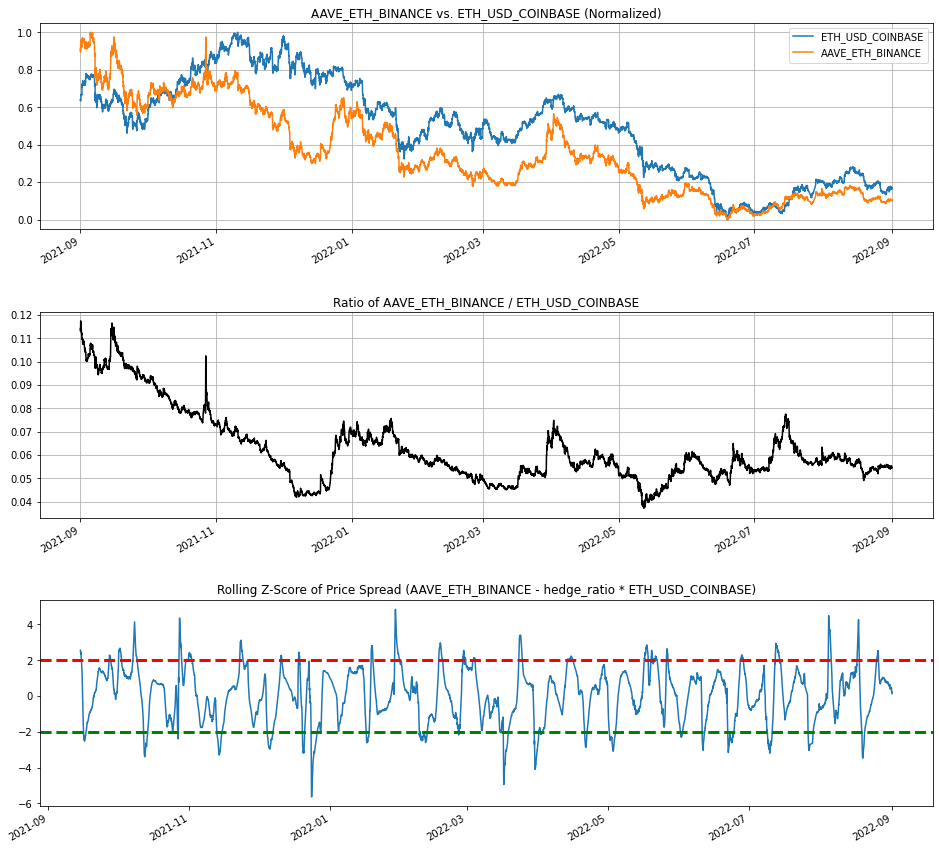

In [7]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 16))
fig.subplots_adjust(hspace=.4)

x = m[X.columns[0]]
y = m[Y.columns[0]]
z = rolling_z_score

plt.subplot(3, 1, 1)
((x - x.min()) / (x.max() - x.min())).plot(label = X.columns[0])
((y - y.min()) / (y.max() - y.min())).plot(label = Y.columns[0], grid = True)
plt.title('{} vs. {} (Normalized)'.format(Y.columns[0], X.columns[0]))
plt.legend()
plt.xlabel('')

plt.subplot(3, 1, 2)
(y / x).plot(title = 'Ratio of {} / {}'.format(Y.columns[0], X.columns[0]), c = 'black', grid = True)
plt.xlabel('')

plt.subplot(3, 1, 3)
z.plot(title = 'Rolling Z-Score of Price Spread ({} - hedge_ratio * {})'.format(Y.columns[0], X.columns[0]))
plt.axhline(-2, c = 'green', linestyle = '--', lw = 3)
plt.axhline(2, c = 'red', linestyle = '--', lw = 3)
plt.xlabel('')

In [178]:
%%time

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import time

from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools import add_constant
from backtesting.lib import crossover, cross
from datetime import timedelta

class PairsTradingBacktester:
    # BACKTESTING PARAMETERS

    # Window size to calculate the rolling z score
    # of the price spread
    z_window = 96

    # Window size to calculate the rollling hedge ratios 
    hedge_ratio_window = 168

    # Value of price spread rolling z score to initiate 
    # a buy
    z_score_upper_thresh = 2

    # Value of price spread rolling z score to initiate 
    # a sell
    z_score_lower_thresh = -2.5

    def __init__(self, 
                 symbol_id_1, 
                 symbol_id_2, 
                 start_date, 
                 end_date, 
                 initial_capital = 10_000, 
                 pct_capital_per_trade = 0.1,
                 comission = 0.01):
        """
        symbol_id_1 - Token we're shorting in the backtest

        symbol_id_2 - Token we're longing in the backtest

        start_date - Start date of the backtest

        end_date - End date of the backtest
        
        initial_captial - Starting capital of the backtest
        
        pct_capital_per_trade - Percent of available capital to allocate to each trade
        
        comission - Percentage deducted from each buy and sell order made
        """

        self.symbol_id_1 = symbol_id_1
        self.symbol_id_2 = symbol_id_2

        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        
        self.initial_capital = initial_capital
        self.pct_capital_per_trade = pct_capital_per_trade
        self.comission = comission

        # Fetch data required for backtest
        self.data = self.get_data()
        
        # Backtest initialized w/ no position
        self.position = 0

        # Number of units long in our current position
        self.curr_position_long_units = 0

        # Number of units short in our current position
        self.curr_position_short_units = 0

        # Trades executed throughout the backtest
        self.trades = pd.DataFrame(columns = ['entry_date', 'exit_date', self.symbol_id_2, self.symbol_id_1])

        #  Long and short positions at each timestep
        self.positions = None

        # PnL in dollars at each timestep
        self.pnl = None

        # Equity at each timestep
        self.equity = None

        # Percent returns at each timestep
        self.returns = None

        # Performance metrics for backtest
        self.performance_metrics = None

        
    ################################# HELPER METHODS #################################

    def __convert_to_usd(self, df, eth):
        if 'ETH_USD' in df.columns[0]:
            return df
        
        m = df.merge(eth, on = 'time_period_end', how = 'inner')
        m[df.columns[0]] = m[df.columns[0]] * m['ETH_USD_COINBASE']
        return m[df.columns[0]].to_frame()
    
    def __rolling_hedge_ratios(self):
        return RollingOLS(
            endog = self.data[self.symbol_id_2].to_frame(),
            exog = add_constant(self.data[self.symbol_id_1].to_frame()),
            window = PairsTradingBacktester.hedge_ratio_window
        ).fit().params[self.symbol_id_1]
    
    def __rolling_spread(self):
        return self.data[self.symbol_id_2] - self.data['rolling_hedge_ratio'] * self.data[self.symbol_id_1]
    
    def __rolling_spread_z_score(self):
        rolling_spread = self.data['rolling_spread']
        return (rolling_spread - rolling_spread.rolling(window = PairsTradingBacktester.z_window).mean()) / rolling_spread.rolling(window = PairsTradingBacktester.z_window).std()
    
    def __generate_entry_signals(self):
        entry_signals = []
        for i in range(len(self.data)):
            if i == 0:
                entry_signals.append(0)
                continue
                
            if (not crossover(self.data.loc[:self.data.index[i], 'rolling_spread_z_score'], PairsTradingBacktester.z_score_lower_thresh) and
                cross(self.data.loc[:self.data.index[i], 'rolling_spread_z_score'], PairsTradingBacktester.z_score_lower_thresh)):
                entry_signals.append(1)
            else:
                entry_signals.append(0)

        return entry_signals

    def __generate_exit_signals(self):
        exit_signals = []
        for i in range(len(self.data)):
            if i == 0:
                exit_signals.append(0)
                continue
                
            if crossover(self.data.loc[:self.data.index[i], 'rolling_spread_z_score'], PairsTradingBacktester.z_score_upper_thresh):
                exit_signals.append(1)
            else:
                exit_signals.append(0)

        return exit_signals
    
    def __close_trade(self, positions, i):
        # Set long and short position amount for current timestamp to 0
        # to simulate closing the trade
        positions.loc[self.data.index[i], self.symbol_id_2] = 0
        positions.loc[self.data.index[i], self.symbol_id_1] = 0
        
        # Set the exit date of the current trade to the current timestamp
        self.trades.loc[len(self.trades) - 1,'exit_date'] = self.data.index[i]

        # Indicate we're no longer in a trade
        self.position = 0
        
        # Calculate pnl and pnl % from trade

        # Entry and exit dates of most current trade
        start = self.trades.loc[len(self.trades) - 1,'entry_date']
        end = self.trades.loc[len(self.trades) - 1,'exit_date']

        # Calculate the PnL from the long position
        start_value_long = self.data.loc[start, self.symbol_id_2] * positions.loc[start, self.symbol_id_2]
        end_value_long = self.data.loc[end, self.symbol_id_2] * positions.loc[start, self.symbol_id_2]
        long_pnl = end_value_long - start_value_long

        # Calculate the PnL from the short position
        start_value_short = self.data.loc[start, self.symbol_id_1] * positions.loc[start, self.symbol_id_1]
        end_value_short = self.data.loc[end, self.symbol_id_1] * positions.loc[start, self.symbol_id_1]
        short_pnl = start_value_short - end_value_short

        # Calculate the PnL from the entire trade 
        trade_pnl = long_pnl + short_pnl
        total_investment = start_value_long + start_value_short
        trade_pnl_pct = trade_pnl / total_investment
        
        # Set the PnL and PnL % of the current trade
        self.trades.loc[len(self.trades) - 1, 'pnl_pct'] = trade_pnl_pct
        self.trades.loc[len(self.trades) - 1, 'pnl'] = trade_pnl

    def __generate_positions(self):
        # Long and short positions throughout backtest
        positions = pd.DataFrame(index = self.data.index, columns = [self.symbol_id_2, self.symbol_id_1])

        # Iterate through each timestamp of dataset
        for i in range(len(self.data)):  

            # Retrieve entry and exit signals at current timestamp          
            entry_signal = self.data.loc[self.data.index[i], 'entry_signals']
            exit_signal = self.data.loc[self.data.index[i], 'exit_signals']

            # If not in a trade at current timestamp
            if not self.position:

                # If entry signal is received
                if entry_signal: 
                    
                    # Amount of dollars to allocate to the long position
                    long_allocation = (1 - self.comission) * self.initial_capital * self.pct_capital_per_trade / 2
                    
                    # Number of units of token2 to long
                    units_long = long_allocation / self.data.loc[self.data.index[i], self.symbol_id_2]
                    
                    # Amount of dollars to allocate to the short position
                    short_allocation = (1 - self.comission) * self.initial_capital * self.pct_capital_per_trade / 2

                    # Number of units of token1 to short
                    units_short = short_allocation / self.data.loc[self.data.index[i], self.symbol_id_1]

                    # Set long and short position amounts for current timestamp
                    positions.loc[self.data.index[i], self.symbol_id_2] = units_long
                    positions.loc[self.data.index[i], self.symbol_id_1] = units_short
                    
                    # Initialize a new trade and append it to the trades DataFrame
                    new_trade = {
                        'entry_date':self.data.index[i],
                        'exit_date':np.nan,
                         self.symbol_id_2:units_long,
                         self.symbol_id_1:units_short,
                        'pnl':np.nan,
                        'pnl_pct':np.nan
                    }
    
                    new_trade = pd.DataFrame(new_trade, index = [0])
                    self.trades = pd.concat([self.trades, new_trade], ignore_index = True)
                    
                    # Track number of units in current long and short position
                    self.curr_position_long_units = units_long
                    self.curr_position_short_units = units_short
                    
                    # Indicate we're in a trade now
                    self.position = 1

                # If exit signal is received
                else:

                    # Set long and short position amounts for current timestamp to 0
                    # since we're not in a trade
                    positions.loc[self.data.index[i], self.symbol_id_2] = 0
                    positions.loc[self.data.index[i], self.symbol_id_1] = 0

            # If in a trade at current timestamp
            else:

                # If exit signal is received
                if exit_signal:

                    # Close the current trade
                    self.__close_trade(positions = positions, i = i)

                # If entry signal is received
                else:

                    # Set long and short position amounts for current timestamp to
                    # the amounts in the current trade since we haven't exited the
                    # current trade yet
                    positions.loc[self.data.index[i], self.symbol_id_2] = self.curr_position_long_units
                    positions.loc[self.data.index[i], self.symbol_id_1] = self.curr_position_short_units
            
            # If the backtest reaches the final timestamp and the current trade hasn't
            # been exited yet 
            if i == len(self.data) - 1 and type(self.trades.loc[len(self.trades) - 1, 'exit_date']) == type(np.nan):

                # Close the current trade
                self.__close_trade(positions = positions, i = i)

        return positions
    
    def __generate_pnl(self):
        pnl_data = pd.DataFrame(index = self.data.index, columns = ['pnl']).fillna(0)
        
        for index, trade in self.trades.iterrows():
            entry_date = trade['entry_date']
            exit_date = trade['exit_date']
            
            units_long = trade[self.symbol_id_2]
            units_short = trade[self.symbol_id_1]
            
            trade_period = self.data.loc[entry_date:exit_date].copy()

            trade_period['long_pnl'] = trade_period[self.symbol_id_2].diff() * units_long
            trade_period['short_pnl'] = -trade_period[self.symbol_id_1].diff() * units_short
            trade_period['total_pnl'] = trade_period['long_pnl'] + trade_period['short_pnl']

            for date in trade_period.index:
                pnl_data.loc[date, 'pnl'] = trade_period.loc[date, 'total_pnl']
                
        return pnl_data

    def __generate_equity_curve(self):
        return (self.initial_capital + self.pnl.cumsum()).rename({'pnl':'equity'}, axis = 1)
    
    def __generate_returns(self):
        return (self.equity / self.initial_capital).rename({'equity':'return'}, axis = 1)
                
    ################################# HELPER METHODS #################################
    
    def get_data(self):
        cols = [
            'price_open', 'price_high', 'price_low', 
            'price_close', 'asset_id_base', 'asset_id_quote', 'exchange_id'
        ]

        df = pd.read_csv(
            '/Users/louisspencer/Desktop/Trading-Bot/src/backtest/backtest_data/price_data_1hr.csv', 
            index_col='time_period_end'
        )[cols]
        
        df.index = pd.to_datetime(df.index)

        df['symbol_id'] = df.asset_id_base + '_' + df.asset_id_quote + '_' + df.exchange_id

        pivot = df.pivot_table(
            index = 'time_period_end',
            columns = 'symbol_id', 
            values = ['price_open', 'price_high', 'price_low', 'price_close']
        )

        eth = pivot['price_close']['ETH_USD_COINBASE'].dropna()
        X = self.__convert_to_usd(pivot['price_close'][self.symbol_id_1].dropna().to_frame(), eth)
        Y = self.__convert_to_usd(pivot['price_close'][self.symbol_id_2].dropna().to_frame(), eth)
        merge = X.merge(Y, on = 'time_period_end', how = 'inner')
        merge = merge[(merge.index >= self.start_date) & (merge.index <= self.end_date)]
        
        return merge
    
    def calculate_performance_metrics(self):
        ########################### HELPER FUNCTIONS ####################################
        def exposure_time(duration):
            exposure = timedelta(days = 0, hours = 0)

            for i in range(len(self.trades)):
                entry_date = pd.to_datetime(self.trades.loc[i, 'entry_date'])
                exit_date = pd.to_datetime(self.trades.loc[i, 'exit_date'])
                trade_duration = exit_date - entry_date
                exposure += trade_duration
            
            return round(exposure / duration * 100, 2)

        def buy_and_hold_return():
            token1_start_value = self.data.loc[self.data.index[0], self.symbol_id_1]
            token1_end_value = self.data.loc[self.data.index[-1], self.symbol_id_1]
            buy_and_hold_return_token_1 = round((token1_end_value - token1_start_value) / token1_start_value * 100, 2)
            
            token2_start_value = self.data.loc[self.data.index[0], self.symbol_id_2]
            token2_end_value = self.data.loc[self.data.index[-1], self.symbol_id_2]
            buy_and_hold_return_token_2 = round((token2_end_value - token2_start_value) / token2_start_value * 100, 2)

            return max([buy_and_hold_return_token_1, buy_and_hold_return_token_2])
        
        def sharpe_ratio():
            hourly_trade_returns = self.trades['pnl_pct']
            mean_hourly_return = hourly_trade_returns.mean()
            std_hourly_return = hourly_trade_returns.std()
            hourly_sharpe_ratio = mean_hourly_return / std_hourly_return
            return hourly_sharpe_ratio * np.sqrt(8760)
                    
        def sortino_ratio():
            hourly_trade_returns = self.trades['pnl_pct']
            mean_hourly_return = hourly_trade_returns.mean()
            std_negative_hourly_return = self.trades[self.trades['pnl_pct'] < 0]['pnl_pct'].std()
            hourly_sortino_ratio = mean_hourly_return / std_negative_hourly_return
            return hourly_sortino_ratio * np.sqrt(8760)
            
        def calmar_ratio():
            try:
                hourly_calmar_ratio = self.trades['pnl_pct'].mean() / abs(max_drawdown() / 100)
                return hourly_calmar_ratio * 8760
            except:
                return np.nan
        
        def max_drawdown():
            rolling_max_equity = self.equity.cummax()
            drawdown = (self.equity / rolling_max_equity) - 1
            max_dd = drawdown.min()
            return round(max_dd * 100, 2)
        
        def avg_drawdown():
            rolling_max_equity = self.equity.cummax()
            drawdown = (self.equity / rolling_max_equity) - 1
            avg_dd = drawdown.mean()
            return round(avg_dd * 100, 2)
        
        def max_drawdown_duration():
            dates = pd.Series([pd.to_datetime(self.start_date)])
            
            diff = self.equity.cummax().diff().fillna(0)
            diff = diff[diff['equity'] != 0]

            for date in diff.index:
                date = pd.to_datetime(date)
                dates = pd.concat([dates, pd.Series(date)], ignore_index = True)

            return dates.diff().max()
        
        def avg_drawdown_duration():
            dates = pd.Series([pd.to_datetime(self.start_date)])
            
            diff = self.equity.cummax().diff().fillna(0)
            diff = diff[diff['equity'] != 0]

            for date in diff.index:
                date = pd.to_datetime(date)
                dates = pd.concat([dates, pd.Series(date)], ignore_index = True)

            return dates.diff().mean()

        def win_rate():
            num_winning_trades = len(self.trades[self.trades['pnl_pct'] > 0])
            num_trades_total = len(self.trades)

            return round(num_winning_trades / num_trades_total * 100, 2)
        ################################################################################
        
        cols = [
            'Start', 'End', 'Duration', 'Exposure Time [%]',
            'Equity Final [$]', 'Equity Peak [$]', 'Return [%]',
            'Buy & Hold Return [%]', 'Sharpe Ratio', 'Sortino Ratio',
            'Calmar Ratio', 'Max. Drawdown [%]', 'Avg. Drawdown [%]',
            'Max. Drawdown Duration', 'Avg. Drawdown Duration', 'Trades',
            'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]', 'Avg. Trade [%]',
            'Max. Trade Duration', 'Avg. Trade Duration'
        ]
        
        performance_metrics = pd.DataFrame(columns = cols)
        
        start = self.start_date
        end = self.end_date
        duration = pd.to_datetime(end) - pd.to_datetime(start)
        
        metrics_dict = {
            'Start':start,
            'End':end, 
            'Duration':duration, 
            'Exposure Time [%]': exposure_time(duration),
            'Equity Final [$]':self.equity.iloc[-1]['equity'],
            'Equity Peak [$]':self.equity['equity'].max(),
            'Return [%]':round((self.returns.iloc[-1]['return'] - 1) * 100, 2),
            'Buy & Hold Return [%]':buy_and_hold_return(),
            'Sharpe Ratio':sharpe_ratio(), 
            'Sortino Ratio':sortino_ratio(),
            'Calmar Ratio':calmar_ratio(), 
            'Max. Drawdown [%]':max_drawdown(),
            'Avg. Drawdown [%]':avg_drawdown(),
            'Max. Drawdown Duration':max_drawdown_duration(), 
            'Avg. Drawdown Duration':avg_drawdown_duration(),
            '# Trades':len(self.trades), 
            'Win Rate [%]':win_rate(), 
            'Best Trade [%]':round(self.trades['pnl_pct'].max() * 100, 2),
            'Worst Trade [%]':round(self.trades['pnl_pct'].min() * 100, 2), 
            'Avg. Trade [%]':round(self.trades['pnl_pct'].mean() * 100, 2),
            'Max. Trade Duration':(pd.to_datetime(self.trades['exit_date']) - pd.to_datetime(self.trades['entry_date'])).max(),
            'Avg. Trade Duration':(pd.to_datetime(self.trades['exit_date']) - pd.to_datetime(self.trades['entry_date'])).mean()
        }

        return pd.DataFrame(metrics_dict)

    def visualize_results(self):
        fig, (a0, a1, a2) = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 10), gridspec_kw={'height_ratios': [0.25, 0.25, 0.5]})
        fig.subplots_adjust(hspace=.5)

        # Plot % returns curve
        plt.subplot(3,1,1)
        
        (self.equity / self.initial_capital).plot(ax = a0, grid = True, title = 'Return [%]')
        
        plt.xlabel('')

        # Plot PnL % for all trades taken
        plt.subplot(3,1,2)
        
        trade_pnl_pct = pd.DataFrame(index = self.data.index, columns = ['pnl_pct']).fillna(0)
        trade_marker_colors = pd.DataFrame(index = self.data.index, columns = ['color']).fillna('green')
        alphas = pd.DataFrame(index = self.data.index, columns = ['alpha']).fillna(0)
        
        for i in range(len(self.trades)):
            exit_date = self.trades.loc[i, 'exit_date']
            pnl_pct = self.trades.loc[i, 'pnl_pct']

            trade_pnl_pct.loc[exit_date, 'pnl_pct'] = pnl_pct * 100
            alphas.loc[exit_date, 'alpha'] = 1

            if pnl_pct > 0:
                trade_marker_colors.loc[exit_date, 'color'] = 'green'
            else:
                trade_marker_colors.loc[exit_date, 'color'] = 'red'

        trade_pnl_pct.reset_index().plot(
            ax = a1,
            kind = 'scatter', 
            x = 'time_period_end', 
            y = 'pnl_pct',
            title = 'Profit / Loss [%]',
            marker = '^', 
            c = trade_marker_colors.color.values, 
            s = 100,
            alpha = alphas.alpha.values,
            grid = True
        )
        
        plt.ylabel('')

        # Plot normalized price data of the two tokens used
        plt.subplot(3,1,3)
        
        prices = self.data[[self.symbol_id_2, self.symbol_id_1]]
        prices = (prices - prices.min()) / (prices.max() - prices.min())

        title = '{} vs. {} (Normalized)'.format(self.symbol_id_2, self.symbol_id_1)

        prices.plot(ax = a2, grid = True, title = title, xlabel = '')
                
    def optimize_parameters(self, optimize_dict, maximize = 'Equity Final [$]'):
        # Your implementation here
        lists = []
        parameter_combinations = []

        for key in optimize_dict.keys():
            lists.append(optimize_dict[key])

        parameter_combinations = list(itertools.product(*lists))
        
    def backtest(self):
        # Calculate rolling hedge ratios at each timestep
        self.data['rolling_hedge_ratio'] = self.__rolling_hedge_ratios()
        
        # Calculate rolling spread at each timestep
        self.data['rolling_spread'] = self.__rolling_spread()
        
        # Calculate rolling spread z score at each timestep
        self.data['rolling_spread_z_score'] = self.__rolling_spread_z_score()

        # Calculate entry signals at each timestep
        self.data['entry_signals'] = self.__generate_entry_signals()

        # Calculate exit signals at each timestep
        self.data['exit_signals'] = self.__generate_exit_signals()
        
        # Calculate long and short positions at each timestep
        self.positions = self.__generate_positions()

        # Calculate PnL in dollars at each timestep
        self.pnl = self.__generate_pnl()

        # Calculate equity at each timestep
        self.equity = self.__generate_equity_curve()

        # Calculate % returns at each timestep
        self.returns = self.__generate_returns()

        # Calculate performance metrics for backtest
        self.performance_metrics = self.calculate_performance_metrics()

# Example usage

optimize_dict = {
    'z_window':[6, 12, 24, 24*2, 24*3, 24*4, 24*5, 24*6, 24*7],
    'hedge_ratio_window':[6, 12, 24, 24*2, 24*3, 24*4, 24*5, 24*6, 24*7],
    'z_thresh_upper':[1.5, 2, 2.5, 3],
    'z_thresh_lower':[-1.5, -2, -2.5, -3]
}

p = PairsTradingBacktester(
    symbol_id_1 = 'ETH_USD_COINBASE',
    symbol_id_2 = 'AAVE_ETH_BINANCE',
    start_date = '2021-09-01',
    end_date = '2022-09-01',
    pct_capital_per_trade = 1,
    initial_capital = 10_000,
    comission = 0.01
)


CPU times: user 1min 2s, sys: 39.3 s, total: 1min 41s
Wall time: 2min 51s


In [179]:
p.backtest()

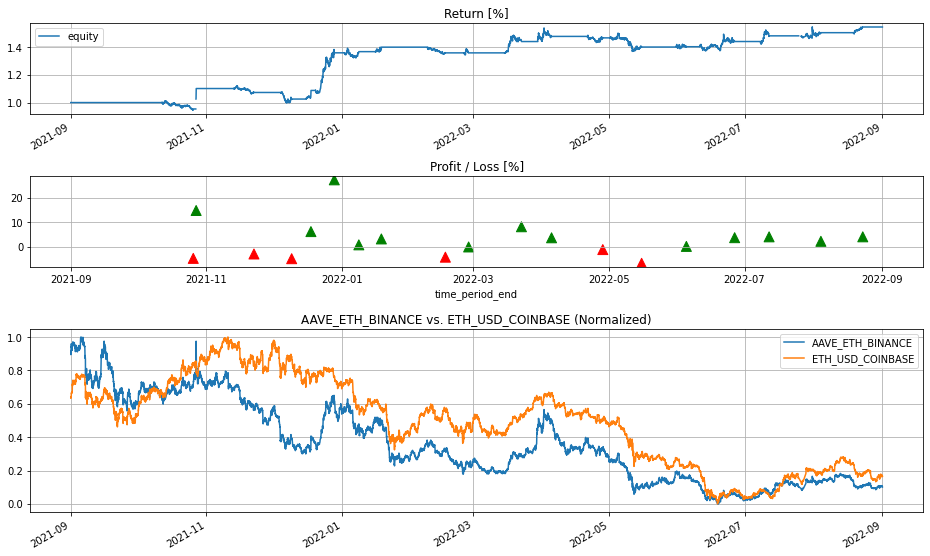

In [180]:
p.visualize_results()

In [181]:
p.performance_metrics.T

,equity
Start,2021-09-01 00:00:00
End,2022-09-01 00:00:00
Duration,365 days 00:00:00
Exposure Time [%],35.71
Equity Final [$],15444.517288
Equity Peak [$],15456.210913
Return [%],54.45
Buy & Hold Return [%],-54.7
Sharpe Ratio,34.4344
Sortino Ratio,142.560005
